# WWQR Mechanism Kinematic Analysis using SciPy

This notebook performs **position, velocity, and acceleration analysis** of a WWQR (Whitworth Quick Return) mechanism using:
- **SymPy** for symbolic differentiation
- **SciPy** for numerical solving (much faster than pure SymPy)
- **NumPy** for efficient array operations

The mechanism consists of two kinematic loops that are solved sequentially to find the motion of slider position **x**.

---

## Import Required Libraries

In [254]:
import numpy as np
import sympy as sp
from IPython.display import Image
import matplotlib.pyplot as plt
from scipy import optimize as op

# Setting up the problem statement and Loop Closure(LC) Equations

### Mechanism Diagram
Visual representation of the complete WWQR mechanism showing all links and joints.

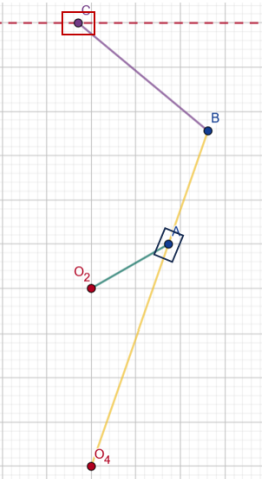

In [252]:
Image('WWQR.png')

---

## Loop Closure Equations

The mechanism is analyzed using **two kinematic loops** that are solved sequentially.

### Loop 1: Four-Bar Linkage (O2-A-O4 triangle)

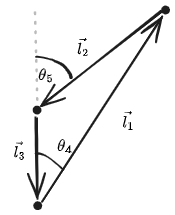

In [215]:
Image('LC1.png')

Loop Closure Equation for Loop - 1
$$
\left\{
\begin{aligned}
    l_1 \cos\theta_4 - l_2 \cos\theta_2 - l_3 &= 0 = f_1(l_1, \theta_4) \\
    l_1 \sin\theta_4 - l_2 \sin\theta_2 &= 0 = f_2(l_1, \theta_4)
\end{aligned}
\right\}
\quad \Rightarrow \text{solve for } l_1, \theta_4
$$

### Loop 2: Slider Mechanism (O4-B-C-slider triangle)

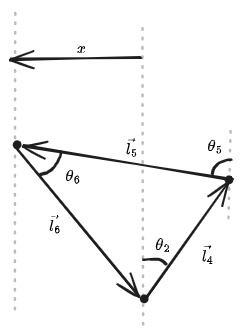

In [216]:
Image('LC2.png')

$$
\left\{
\begin{aligned}
    l_3 \cos\theta_4 + l_5 \cos\theta_5 - l_6 \cos\theta_6 &= 0 = g_1(x, \theta_5) \\
    l_4 \sin\theta_4 - l_5 \sin\theta_5 - x &= 0 = g_2(x, \theta_5)
\end{aligned}
\right\}

\quad \Rightarrow \text{solve for } x, \theta_5
$$

Positions are obtained by solving the $f$ equations for $\theta_4$, and substituting it in the $g$ equations to find $x$, and $\theta_5$\
Velocity and acceleration is just derived from $\dot{f_i}$ and $\dot{g_i}$, which becomes linear system of equations.

---

## Define Mechanism Dimensions

Set up the link lengths for the WWQR mechanism:
- **O2A** = 1 m (crank length)
- **O2O4** = 2 m (fixed distance between ground pivots)
- **O4B** = 4 m (rocker length)
- **BC** = 1.9 m (connecting rod to slider)

In [269]:
O2A = 1
O2O4 = 2
O4B = 4
BC = 1.9


OMEGA = 1  # rad/s
ALPHA = 0  # rad/s²

---

# Main Solver Function

## Pre-computation Strategy (for Speed)

How is this different from the previous commits/versions:
1. **Define symbolic expressions ONCE** (outside the function)
2. **Lambdify ONCE** (convert to fast NumPy functions)
3. **Only numerical solving happens inside** the function

This approach is ~100x faster than recomputing symbolic expressions on each call.

## Function: `full_solve(theta2val)`

Solves the complete kinematic analysis for a given crank angle θ₂:

**Input:** 
- `theta2val` (float): Crank angle in radians

**Output:** 
- List of 3 NumPy arrays: `[positions, velocities, accelerations]`
  - `positions` = `[l1, theta4, x, theta5]`
  - `velocities` = `[dotl1, dottheta4, dotx, dottheta5]`
  - `accelerations` = `[ddotl1, ddottheta4, ddotx, ddottheta5]`
- Returns `None` if no valid solution exists

**Solution Strategy:**
1. **Position Analysis**: Solve nonlinear loop equations using `fsolve`
2. **Velocity Analysis**: Solve linear system from differentiated equations
3. **Acceleration Analysis**: Solve linear system from second derivatives

In [219]:
# Create all symbolic expressions and lambdified functions ONCE to save compute space and time while execution
t = sp.symbols("t")
l1 = sp.Function("l_1")(t)
theta4 = sp.Function("theta_4")(t)
x = sp.Function("x")(t)
theta5 = sp.Function("theta_5")(t)
theta2 = sp.Function("theta_2")(t)


f1 = l1*sp.cos(theta4)-O2A*sp.cos(theta2)-O2O4
f2 = l1*sp.sin(theta4)-O2A*sp.sin(theta2)
g1 = O4B*sp.cos(theta4)+BC*sp.cos(theta5)-4
g2 = O4B*sp.sin(theta4)-BC*sp.sin(theta5)-x

F = [f1, f2, g1, g2]


f1_lam = sp.lambdify((l1, theta4, theta2), f1, modules="numpy")
f2_lam = sp.lambdify((l1, theta4, theta2), f2, modules="numpy")
g1_lam = sp.lambdify((x, theta5, theta4), g1, modules="numpy")
g2_lam = sp.lambdify((x, theta5, theta4), g2, modules="numpy")


dotl1 = sp.Function("l_1d")(t)
dotx = sp.Function("x_d")(t)
dottheta4 = sp.Function("theta_4d")(t)
dottheta5 = sp.Function("theta_5d")(t)
ddotl1 = sp.Function("l_1dd")(t)
ddotx = sp.Function("x_dd")(t)
ddottheta4 = sp.Function("theta_4dd")(t)
ddottheta5 = sp.Function("theta_5dd")(t)

dotF = [sp.diff(f, t) for f in F]

def full_solve(theta2val: float) -> list:
    '''
    Returns positions, velocities and accelerations
    Takes in theta2val (float) in radians
    Returns the following list:
    [deg1_soln, solve2deg, solve3deg]
    where:
    deg1_soln = np.array([l1i, theta4i, xi, theta5i] (all floats)
    solve2deg = np.array([dotl1, dottheta4, dotx, dottheta5] (all floats)
    solve3deg = np.array([ddotl1, ddottheta4, ddotx, ddottheta5] (all floats)
    If no valid solution exists, returns None
    '''
    # Solve position equations
    f_sol = op.fsolve(
        func=lambda x: [f1_lam(x[0], x[1], theta2val), 
                       f2_lam(x[0], x[1], theta2val)], 
        x0=np.array([3, 1]))
    
    if f_sol[0] < 0:
        return None
    
    theta4i = float(f_sol[1])
    l1i = float(f_sol[0])
    
    g_sol = op.fsolve(
        func=lambda vars: [g1_lam(vars[0], vars[1], theta4i), 
                          g2_lam(vars[0], vars[1], theta4i)], 
        x0=np.array([3, 1]))
    
    xi = float(g_sol[0])
    theta5i = float(g_sol[1])
    
    if not (theta5i <= np.pi/2):
        return None
    
    deg1_soln = np.array([l1i, theta4i, xi, theta5i])
    
    # Velocity analysis
    subs2degdict = {
        sp.Derivative(theta4, t): dottheta4,
        sp.Derivative(l1, t): dotl1,
        sp.Derivative(x, t): dotx,
        sp.Derivative(theta5, t): dottheta5,
        theta4: theta4i, l1: l1i, x: xi, theta5: theta5i,
        sp.Derivative(theta2, t): OMEGA, theta2: theta2val
    }
    
    dotF_val = [dotf.subs(subs2degdict).evalf() for dotf in dotF]
    dotF_lam = [sp.lambdify([dotl1, dottheta4, dotx, dottheta5], 
                           dotf_val, modules="numpy")
               for dotf_val in dotF_val]
    
    solve2deg = op.fsolve(
        func=lambda x: [dotf_lam(x[0], x[1], x[2], x[3]) for dotf_lam in dotF_lam],
        x0=np.array([0, 0, 0, 0]))
    
    # Acceleration analysis
    subs3degdict = {
        sp.Derivative(l1, t): solve2deg[0], 
        sp.Derivative(theta4, t): solve2deg[1], 
        sp.Derivative(x, t): solve2deg[2], 
        sp.Derivative(theta5, t): solve2deg[3],
        sp.Derivative(theta4, t, t): ddottheta4, 
        sp.Derivative(l1, t, t): ddotl1, 
        sp.Derivative(x, t, t): ddotx, 
        sp.Derivative(theta5, t, t): ddottheta5,
        theta4: theta4i, l1: l1i, x: xi, theta5: theta5i,
        sp.Derivative(theta2, t, t): ALPHA, 
        sp.Derivative(theta2, t): OMEGA, theta2: theta2val
    }
    
    ddotF_val = [sp.diff(dotf, t).subs(subs3degdict).evalf() for dotf in dotF]
    ddotF_lam = [sp.lambdify([ddotl1, ddottheta4, ddotx, ddottheta5],
                            ddotfval, modules="numpy") 
                for ddotfval in ddotF_val]
    
    solve3deg = op.fsolve(
        func=lambda x: [ddotf_lam(x[0], x[1], x[2], x[3]) for ddotf_lam in ddotF_lam],
        x0=np.array([0, 0, 0, 0]))
    
    return [deg1_soln, solve2deg, solve3deg]

---

## Test the Solver

### Single Point Test
Verify the solver works correctly for θ₂ = 30° (π/6 radians).

In [220]:
full_solve(np.pi/6)

[array([ 2.90931291,  0.17271936, -1.21162009,  1.53946711]),
 array([-0.34372377,  0.32278096,  1.27886733, -0.11684417]),
 array([-0.63595663, -0.04187545, -0.19871621, -0.20145399])]

### Performance Benchmark
Measure computation time for a single angle. 

**Expected:** ~0.01-0.05 seconds (much faster than pure SymPy which takes ~1 second)

In [246]:
import time
starttime = time.time()
final_x = full_solve(40*np.pi/180)
endtime = time.time()
print(f"Time to calculate: {endtime-starttime:.4f} s")
# print("Final x: ", final_x)

Time to calculate: 0.0451 s


---

# Complete Kinematic Analysis Over Full Rotation

## Generate Position, Velocity, and Acceleration Plots

Compute slider kinematics for one complete crank rotation (0° to 360°).

### Performance vs. Resolution Trade-off

**Time consideration:** Each angle takes ~0.01-0.05 seconds to compute.

- **100 points** → ~7 seconds total
- **300 points** → ~21 seconds (good resolution)
- **1000 points** → ~70 seconds (high resolution)

Choose resolution based on your needs: higher resolution gives smoother curves but takes longer.

In [249]:
Ntheta2deg = 300
theta2list = np.linspace(0, 361, Ntheta2deg) * np.pi / 180
xlist = []
for th in theta2list:
    sol = full_solve(th)
    if sol is None:
        xlist.append([np.nan, np.nan, np.nan])
        continue
    deg1, deg2, deg3 = sol
    # Ensure arrays are flattened and extract scalars properly
    xlist.append([
        float(np.asarray(deg1[2]).item()),
        float(np.asarray(deg2[2]).item()),
        float(np.asarray(deg3[2]).item())
    ])
xlist = np.array(xlist)

### Compute Slider Kinematics for Full Cycle

Loop through all crank angles and extract slider data:
- **Position** (x): `deg1[2]` - horizontal position of slider
- **Velocity** (ẋ): `deg2[2]` - slider speed
- **Acceleration** (ẍ): `deg3[2]` - slider acceleration

Invalid solutions (if any) are filled with `NaN`.

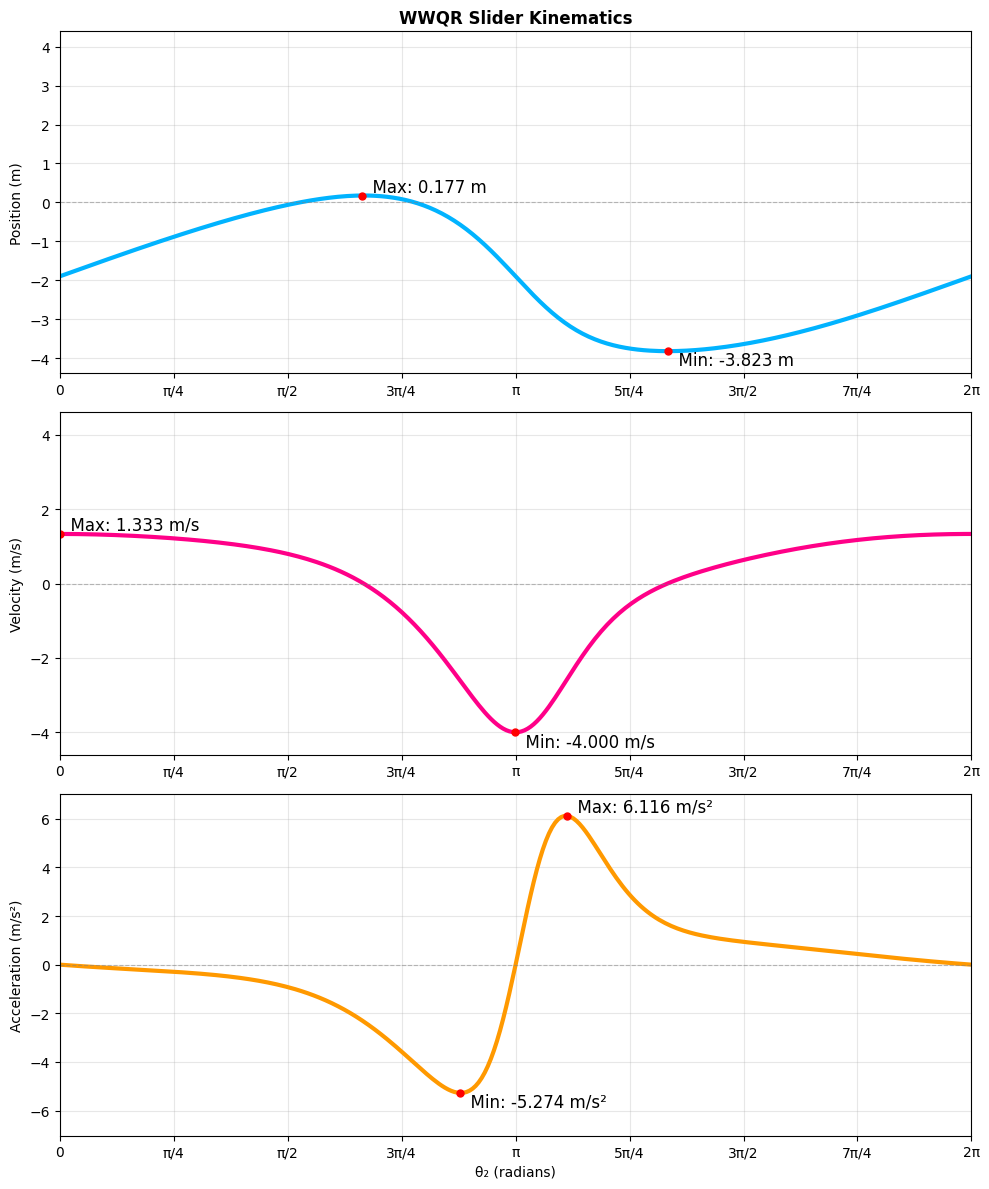

In [271]:
theta2_rad = theta2list
theta2_deg = theta2list * 180 / np.pi

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
colors = ["#01B3FF", "#FF0088", "#FF9900"]

# Position plot
axes[0].plot(theta2_rad, xlist[:, 0], color=colors[0], linewidth=3)
axes[0].set_ylabel('Position (m)', fontsize=10)
axes[0].axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
axes[0].set_title('WWQR Slider Kinematics', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
maxabs_pos = np.nanmax(np.abs(xlist[:, 0]))
axes[0].set_ylim(-maxabs_pos * 1.15, maxabs_pos * 1.15)

# Annotate max and min for position
if not np.all(np.isnan(xlist[:, 0])):
    idx_max = np.nanargmax(xlist[:, 0])
    idx_min = np.nanargmin(xlist[:, 0])
    axes[0].plot(theta2_rad[idx_max], xlist[idx_max, 0], 'ro', markersize=5)
    axes[0].plot(theta2_rad[idx_min], xlist[idx_min, 0], 'ro', markersize=5)
    axes[0].text(theta2_rad[idx_max], xlist[idx_max, 0], 
                f'  Max: {xlist[idx_max, 0]:.3f} m', fontsize=12, va='bottom')
    axes[0].text(theta2_rad[idx_min], xlist[idx_min, 0], 
                f'  Min: {xlist[idx_min, 0]:.3f} m', fontsize=12, va='top')

# Velocity plot
axes[1].plot(theta2_rad, xlist[:, 1], color=colors[1], linewidth=3)
axes[1].set_ylabel('Velocity (m/s)', fontsize=10)
axes[1].axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)
maxabs_vel = np.nanmax(np.abs(xlist[:, 1]))
axes[1].set_ylim(-maxabs_vel * 1.15, maxabs_vel * 1.15)

# Annotate max and min for velocity
if not np.all(np.isnan(xlist[:, 1])):
    idx_max = np.nanargmax(xlist[:, 1])
    idx_min = np.nanargmin(xlist[:, 1])
    axes[1].plot(theta2_rad[idx_max], xlist[idx_max, 1], 'ro', markersize=5)
    axes[1].plot(theta2_rad[idx_min], xlist[idx_min, 1], 'ro', markersize=5)
    axes[1].text(theta2_rad[idx_max], xlist[idx_max, 1], 
                f'  Max: {xlist[idx_max, 1]:.3f} m/s', fontsize=12, va='bottom')
    axes[1].text(theta2_rad[idx_min], xlist[idx_min, 1], 
                f'  Min: {xlist[idx_min, 1]:.3f} m/s', fontsize=12, va='top')

# Acceleration plot
axes[2].plot(theta2_rad, xlist[:, 2], color=colors[2], linewidth=3)
axes[2].set_ylabel('Acceleration (m/s²)', fontsize=10)
axes[2].axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)
maxabs_acc = np.nanmax(np.abs(xlist[:, 2]))
axes[2].set_ylim(-maxabs_acc * 1.15, maxabs_acc * 1.15)

# Annotate max and min for acceleration
if not np.all(np.isnan(xlist[:, 2])):
    idx_max = np.nanargmax(xlist[:, 2])
    idx_min = np.nanargmin(xlist[:, 2])
    axes[2].plot(theta2_rad[idx_max], xlist[idx_max, 2], 'ro', markersize=5)
    axes[2].plot(theta2_rad[idx_min], xlist[idx_min, 2], 'ro', markersize=5)
    axes[2].text(theta2_rad[idx_max], xlist[idx_max, 2], 
                f'  Max: {xlist[idx_max, 2]:.3f} m/s²', fontsize=12, va='bottom')
    axes[2].text(theta2_rad[idx_min], xlist[idx_min, 2], 
                f'  Min: {xlist[idx_min, 2]:.3f} m/s²', fontsize=12, va='top')

# Set x-axis with radians on bottom
axes[2].set_xlabel('θ₂ (radians)', fontsize=10)
axes[2].set_xlim(0, 2*np.pi)

# Set radian ticks at multiples of π/4 and show tick labels on all subplots
radian_ticks = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 
                        5*np.pi/4, 3*np.pi/2, 7*np.pi/4, 2*np.pi])
radian_labels = ['0', 'π/4', 'π/2', '3π/4', 'π', 
                '5π/4', '3π/2', '7π/4', '2π']

for ax in axes:
    ax.set_xticks(radian_ticks)
    ax.set_xticklabels(radian_labels)
    ax.tick_params(axis='x', which='both', labelbottom=True)  # ensure labels visible on all subplots

plt.tight_layout()
plt.show()

---

# Playground / Testing Area

This section is for experimental code and testing. Keep test functions with different names to avoid overwriting the main `full_solve` function.

In [225]:
def full_solve_pg(theta2val: float) -> list:
    f1 = l1*sp.cos(theta4)-O2A*sp.cos(theta2)-O2O4
    f2 = l1*sp.sin(theta4)-O2A*sp.sin(theta2)

    f1_lam = sp.lambdify((l1, theta4, theta2), f1, modules="numpy")
    f2_lam = sp.lambdify((l1, theta4, theta2), f2, modules="numpy")

    f_sol = op.fsolve(
        func=lambda x: [f1_lam(x[0], x[1], theta2val),
                        f2_lam(x[0], x[1], theta2val)],
        x0=np.array([3, 1]))
    return f_sol

In [226]:
type(full_solve_pg(2*np.pi/3))

numpy.ndarray